In [4]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import cm
from keras.datasets.cifar10 import load_data

import random
import numpy as np

In [5]:
def DataLoad(subset=None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  
  if subset is not None:
    train_length = int(len(x_train) * subset)
    x_train = x_train[:train_length]
    y_train = y_train[:train_length]
    
    test_length = int(len(x_test) * subset)
    x_test = x_test[:test_length]
    y_test = y_test[:test_length]
  
  val_split = 0.2
  val_length = int(len(x_train) * val_split)
  x_val = x_train[:val_length]
  y_val = y_train[:val_length]
  
  x_train = x_train[val_length:]
  y_train = y_train[val_length:]
  
  return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = DataLoad()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((40000, 32, 32, 3),
 (40000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 (10000, 32, 32, 3),
 (10000, 1))

In [7]:
# Labels
lables = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

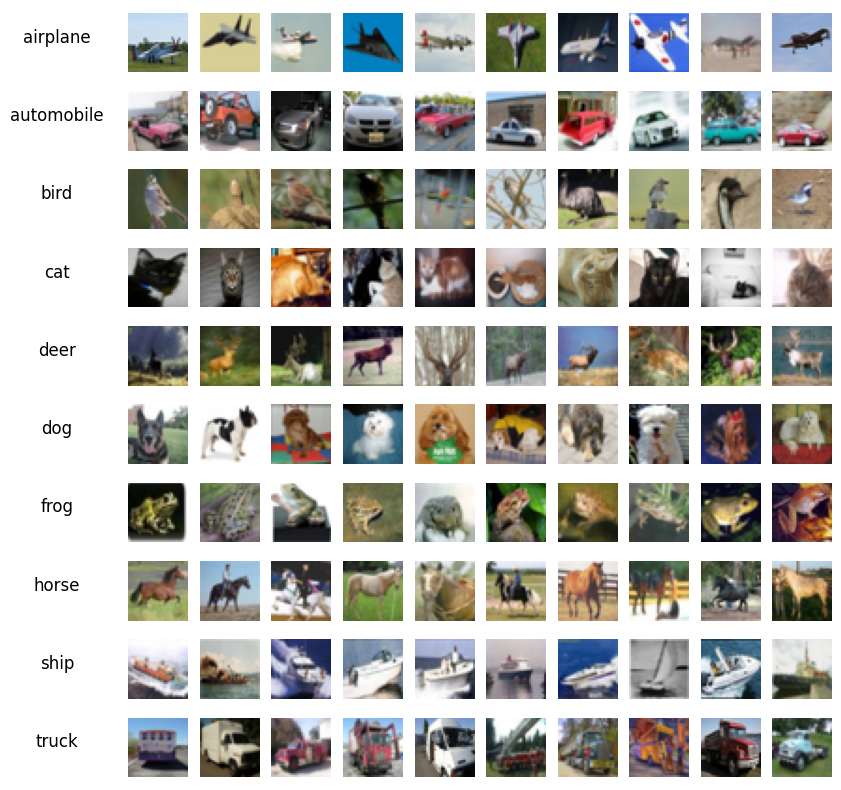

In [8]:
# Plot the 10 images from each label
fig, axes = plt.subplots(10, 11, figsize=(10, 10))

for i in range(10):
    axes[i, 0].text(0, 0.5, lables[i], fontsize=12, ha='center')
    axes[i, 0].axis('off')
    for j in range(1, 11):  # Modify the range to start from 1 instead of 0
        index = random.choice(np.where(y_train == i)[0])
        axes[i, j].imshow(x_train[index])
        axes[i, j].axis('off')

In [9]:
import numpy as np

x_train_reshaped = np.moveaxis(x_train, -1, 1)  # Move channel dimension to second position
x_train_reshaped = x_train_reshaped.reshape(x_train_reshaped.shape[0], 32, 32*3)  # Reshape to (num_samples, 32, 32*3)

x_val_reshaped = np.moveaxis(x_val, -1, 1)  # Move channel dimension to second position
x_val_reshaped = x_val_reshaped.reshape(x_val_reshaped.shape[0], 32, 32*3)  # Reshape to (num_samples, 32, 32*3)

# convert to float32
x_train_reshaped = x_train_reshaped.astype('float32')
x_val_reshaped = x_val_reshaped.astype('float32')

# Now x_train_reshaped has the shape (num_samples, 32, 96), which is compatible with LSTM input shape
x_train_reshaped.shape, x_train_reshaped[0].shape, x_val_reshaped.shape, x_val_reshaped[0].shape

((40000, 32, 96), (32, 96), (10000, 32, 96), (32, 96))

In [27]:
from keras.layers import LSTM, Dense, Flatten
@keras.saving.register_keras_serializable()
class RowLSTM(tf.keras.Model):
    def __init__(self, num_classes):
        super(RowLSTM, self).__init__()
        self.num_classes = num_classes
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(256, return_sequences=True)
        self.flatten = Flatten()
        self.output_layer = Dense(num_classes, activation='softmax')
        
    def build(self, input_shape):
        super(RowLSTM, self).build(input_shape)
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "num_classes": keras.saving.serialize_keras_object(self.num_classes),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # add all parameters to the config
        for key in config:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        
        return cls(**config)
    
    def call(self, x):
        # Reshape input to fit LSTM input shape
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

num_classes = 10  # CIFAR-10 has 10 classes
model_rowlstm = RowLSTM(num_classes)

# Input shape for CIFAR-10 images
input_shape = (32, 32, 3)

model_rowlstm.build(input_shape=(None, *input_shape))  # None for batch size

model_rowlstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [36]:
from keras.layers import Bidirectional, LSTM, Dense, Flatten
@keras.saving.register_keras_serializable()
class BiLSTM(tf.keras.Model):
    def __init__(self, num_classes):
        super(BiLSTM, self).__init__()
        self.num_classes = num_classes
        self.bilstm1 = Bidirectional(LSTM(128, return_sequences=True))
        self.bilstm2 = Bidirectional(LSTM(256, return_sequences=True))
        self.flatten = Flatten()
        self.output_layer = Dense(num_classes, activation='softmax')
        
    def build(self, input_shape):
        super(BiLSTM, self).build(input_shape)

    def call(self, x):
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "num_classes": keras.saving.serialize_keras_object(self.num_classes),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # add all parameters to the config
        for key in config:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        
        return cls(**config)

num_classes = 10  # CIFAR-10 has 10 classes
model_bilstm = BiLSTM(num_classes)

# Input shape for CIFAR-10 images
input_shape = (32, 32, 3)

model_bilstm.build(input_shape=(None, *input_shape))  # None for batch size

model_bilstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [73]:
from keras.layers import Bidirectional, LSTM, Dense, Flatten, Reshape, Conv2D
from keras import Input, Model

@keras.saving.register_keras_serializable()
class RowLSTMGen(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(RowLSTMGen, self).__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.inputs = Input(shape=self.input_shape)
        self.reshape = Reshape((32, -1))  # Reshape to (32, -1) for LSTM input
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(256, return_sequences=True)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(32*32*3, activation=None)
        self.reshape_back = Reshape((32, 32, 3))
        
    def call(self, x):
        x = self.reshape(x)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape_back(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "input_shape": keras.saving.serialize_keras_object(self.input_shape),
            "num_classes": keras.saving.serialize_keras_object(self.num_classes),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # add all parameters to the config
        for key in config:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        
        return cls(**config)
    
    def model(self):
        return Model(inputs=self.inputs, outputs=self.call(self.inputs)[:, :, :, :3])  # Adjusting the output shape
    
    
# Input shape for CIFAR-10 images
input_shape = (32, 32, 3)

num_classes = 10  # CIFAR-10 has 10 classes

# Model definition
model_rowLSTMGen = RowLSTMGen(input_shape, num_classes)

# Compile the model with Mean Squared Error (MSE) loss
model_rowLSTMGen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Display model summary
model_rowLSTMGen.model().summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 32, 128)        │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 32, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3072)           │       396,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_4 (GetItem)            │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,954,432 (7.46 MB)

 Trainable params: 1,954,432 (7.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.layers import Bidirectional, LSTM, Dense, Flatten, Reshape, Conv2D
from keras import Input, Model

@keras.saving.register_keras_serializable()
class BiLSTMGen(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(RowLSTMGen, self).__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.inputs = Input(shape=self.input_shape)
        self.reshape = Reshape((32, -1))  # Reshape to (32, -1) for LSTM input
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(256, return_sequences=True)
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(32*32*3, activation=None)
        self.reshape_back = Reshape((32, 32, 3))
        
    def call(self, x):
        x = self.reshape(x)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape_back(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        config = {
            "input_shape": keras.saving.serialize_keras_object(self.input_shape),
            "num_classes": keras.saving.serialize_keras_object(self.num_classes),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        # add all parameters to the config
        for key in config:
            config[key] = keras.saving.deserialize_keras_object(config[key])
        
        return cls(**config)
    
    def model(self):
        return Model(inputs=self.inputs, outputs=self.call(self.inputs)[:, :, :, :3])  # Adjusting the output shape
    
    
# Input shape for CIFAR-10 images
input_shape = (32, 32, 3)

num_classes = 10  # CIFAR-10 has 10 classes

# Model definition
model_rowLSTMGen = RowLSTMGen(input_shape, num_classes)

# Compile the model with Mean Squared Error (MSE) loss
model_rowLSTMGen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Display model summary
model_rowLSTMGen.model().summary()

In [55]:
# Train the rowlstm
history_rowlstm = model_rowlstm.fit(x_train_reshaped, y_train, epochs=20, validation_data=(x_val_reshaped, y_val))

In [17]:
# Train the bilstm
history_bilstm = model_bilstm.fit(x_train_reshaped, y_train, epochs=20, validation_data=(x_val_reshaped, y_val))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.2744 - loss: 2.0142 - val_accuracy: 0.3518 - val_loss: 1.8245
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3464 - loss: 1.8329 - val_accuracy: 0.3736 - val_loss: 1.7391
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.3767 - loss: 1.7377 - val_accuracy: 0.3959 - val_loss: 1.6944
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.3860 - loss: 1.7287 - val_accuracy: 0.3862 - val_loss: 1.7023
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4057 - loss: 1.6615 - val_accuracy: 0.4164 - val_loss: 1.6259
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.4260 - loss: 1.6156 - val_accuracy: 0.4227 - val_loss: 1.6194
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4390 - loss: 1.5776 - val_accuracy: 0.4253 - val_loss: 1.5896
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4408 -

In [83]:
# Train the rowLSTMGen
x_train_32 = x_train.astype(np.float32)
x_val_32 = x_val.astype(np.float32)

history_rowLSTMGen = model_rowLSTMGen.fit(x_train_32, x_train_32, epochs=20, validation_data=(x_val_32, x_val_32))

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6846 - loss: 999.2368 - val_accuracy: 0.6924 - val_loss: 889.1018
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6945 - loss: 872.5916 - val_accuracy: 0.7038 - val_loss: 796.3635
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7067 - loss: 783.3458 - val_accuracy: 0.7230 - val_loss: 725.1747
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7157 - loss: 713.2307 - val_accuracy: 0.6977 - val_loss: 667.9275
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7154 - loss: 656.2680 - val_accuracy: 0.7245 - val_loss: 622.9202
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7200 - loss: 608.9609 - val_accuracy: 0.7253 - val_loss: 583.8651
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7248 - loss: 583.1921 - val_accuracy: 0.7203 - val_loss: 565.5245
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accu

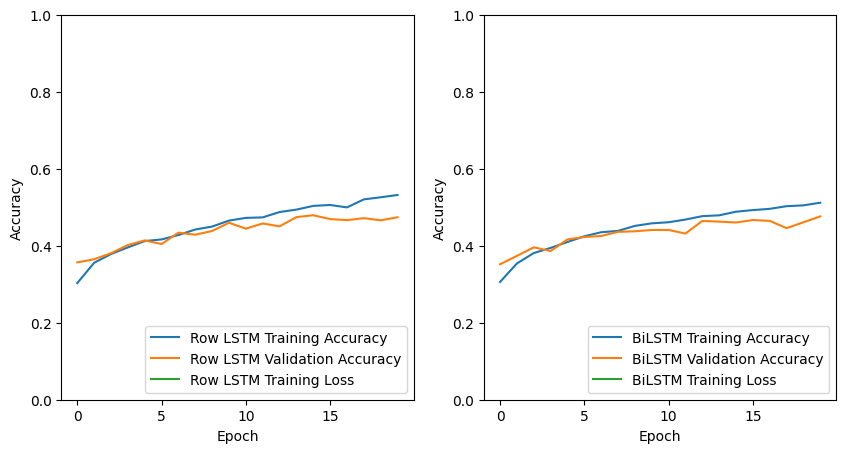

In [18]:
# Plot the training history 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rowlstm.history['accuracy'], label='Row LSTM Training Accuracy')
plt.plot(history_rowlstm.history['val_accuracy'], label='Row LSTM Validation Accuracy')
plt.plot(history_rowlstm.history['loss'], label='Row LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['accuracy'], label='BiLSTM Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM Validation Accuracy')
plt.plot(history_bilstm.history['loss'], label='BiLSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.show()

In [19]:

x_test_reshaped = np.moveaxis(x_test, -1, 1)  # Move channel dimension to second position
x_test_reshaped = x_test_reshaped.reshape(x_test_reshaped.shape[0], 32, 32*3)  # Reshape to (num_samples, 32, 32*3)

# convert to float32
x_test_reshaped = x_test_reshaped.astype('float32')

x_test_reshaped.shape, x_test_reshaped[0].shape

((10000, 32, 96), (32, 96))

In [29]:
# test model

# Save the model with accuracy
path = ''

test_loss, test_acc = model_rowlstm.evaluate(x_test_reshaped,  y_test, verbose=2)

print(f"Row LSTM: {test_acc}")

model_name = 'rowlstm'

keras.saving.save_model(model_rowlstm, path + model_name + '_' + str(int(test_acc*100)) + '.keras')


test_loss, test_acc = model_bilstm.evaluate(x_test_reshaped,  y_test, verbose=2)

print(f"Bi LSTM: {test_acc}")

model_name = 'bilstm'

keras.saving.save_model(model_bilstm, path + model_name + '_' + str(int(test_acc*100)) + '.keras')


test_loss, test_acc = model_bilstm.evaluate(x_test_reshaped,  y_test, verbose=2)

print(f"Bi LSTM: {test_acc}")

model_name = 'bilstm'

keras.saving.save_model(model_bilstm, path + model_name + '_' + str(int(test_acc*100)) + '.keras')

313/313 - 2s - 5ms/step - accuracy: 0.1011 - loss: 2.3354
Row LSTM: 0.10109999775886536
313/313 - 2s - 8ms/step - accuracy: 0.0979 - loss: 2.3810
Bi LSTM: 0.09790000319480896


In [31]:
# load models

# model_rowlstm = keras.models.load_model('rowlstm_10.keras')

# model_rowlstm = keras.models.load_model('../models/rowlstm_48.keras')



In [84]:
import numpy as np
from tqdm import tqdm

def generate_fake_samples(model, x_test):
    def deprocess_image(x):
        # Stack the image back to 3 channels
        x = x.reshape((32, 32, 3))
        # Ensure the pixel values are between 0 and 1
        x = np.clip(x, 0, 1)
        # Convert to image
        x = (x * 255).astype(np.uint8)
        return x

    # convert x_test to float32
    x_test = x_test.astype(np.float32)

    _x_test = x_test / 255.0

    # Step 1: Generate Real Samples
    random_idx = np.random.choice(range(len(x_test)))
    real_samples = _x_test[random_idx:random_idx+1]

    # Step 2: Generate Fake Samples
    num_fake_samples = len(real_samples)  # Generate the same number of fake samples as real samples

    fake_samples = []

    for sample_idx in range(num_fake_samples):
        pixels = real_samples[sample_idx].copy()
        for row in tqdm(range(32)):
            for col in range(32):
                for channel in range(3):
                    # Use the model to predict the pixel values.
                    # Use real samples to predict the fake samples
                    probs = model.predict(real_samples, verbose=0)[sample_idx, row, col, channel]
                    # Ensure the pixel values are between 0 and 1
                    probs = np.clip(probs, 0, 1)
                    # Update the pixel values in the image frame.
                    pixels[row, col, channel] = probs
        fake_samples.append(deprocess_image(pixels))

    # Convert the list of fake samples to a NumPy array
    fake_samples = np.array(fake_samples)

    # Deprocess the real samples
    real_samples_deprocessed = [deprocess_image(sample) for sample in real_samples]

    return real_samples_deprocessed, fake_samples

real_samples, fake_samples = generate_fake_samples(model_rowLSTMGen, x_test[0:1])
print("Shape of real samples:", real_samples[0].shape)
print("Shape of fake samples:", fake_samples.shape)

100%|██████████| 32/32 [03:01<00:00,  5.66s/it]

Shape of real samples: (32, 32, 3)
Shape of fake samples: (1, 32, 32, 3)


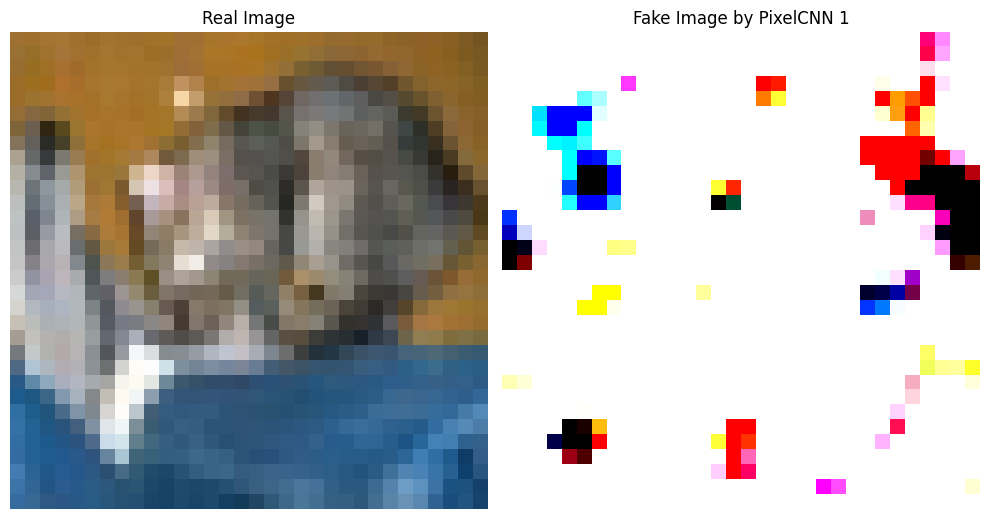

In [85]:
import matplotlib.pyplot as plt

# Number of pairs of real and fake samples to plot
num_pairs = min(len(real_samples), len(fake_samples))

# Plot real vs fake samples
fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 10*num_pairs))
if num_pairs < 2:
    axes = axes.reshape(1, 2)  # Reshape axes to have 1 row

for i in range(num_pairs):
    axes[i, 0].imshow(real_samples[i].astype(np.uint8))
    axes[i, 0].set_title("Real Image")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(fake_samples[i].astype(np.uint8))
    axes[i, 1].set_title("Fake Image by PixelCNN 1")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()